In [2]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *
from gaussian_process_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [2]:
# Compute a "true" reference covariance matrix
num_images = 4000
num_patches = 4000
edge_crop = 32
channel = 'LED119'
ev_floor = 1e-4
key = jax.random.PRNGKey(0)

# patch_sizes = [2, 4, 6, 8, 10]
patch_sizes = [2, 3, 4, 5, 6]

images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)

cov_mats_stationary_pd = {}
means = {}
patches_by_size = {}
print('loading patches')
patches = extract_patches(images, onp.max(patch_sizes), num_patches=num_patches)

for patch_size in tqdm(patch_sizes):
    if patch_size == onp.max(patch_sizes):
         patches_by_size[patch_size] = patches
    else:
        # draw subpatches from the larger patches
        offsets = jax.random.randint(key, (num_patches, 2), 0, onp.max(patch_sizes) - patch_size)
        key, subkey = jax.random.split(key)
        subpatches = []
        for i in range(num_patches):
            subpatches.append(patches[i, offsets[i, 0]:offsets[i, 0] + patch_size, offsets[i, 1]:offsets[i, 1] + patch_size])
        patches_by_size[patch_size] = np.array(subpatches)

print('computing cov mats')
for patch_size in tqdm(patch_sizes):
    patches = patches_by_size[patch_size]
    # cov_mat = compute_cov_mat(patches)
    # cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=ev_floor, show_plot=False)
    cov_mat_stationary = compute_stationary_cov_mat(patches)
    cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=ev_floor, show_plot=False)
    means[patch_size] = np.mean(patches)
    cov_mats_stationary_pd[patch_size] = cov_mat_stationary_pd
    

loading patches


100%|██████████| 5/5 [02:11<00:00, 26.32s/it]


computing cov mats


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


In [3]:

# verify that direct likelihood and iterative likelihood are the same
patch_size_to_test = 6


test_patch = patches_by_size[patch_size_to_test][0]
samples = test_patch.reshape(-1, test_patch.shape[-2], test_patch.shape[-1])


cov_mat = cov_mats_stationary_pd[patch_size_to_test]
# cov_mat = np.eye(cov_mat.shape[0])
mean = means[patch_size_to_test]

direct = []
for sample in tqdm(samples):
    direct.append(jax.scipy.stats.multivariate_normal.logpdf(sample.reshape(-1), mean=mean * np.ones(cov_mat.shape[0]), cov=cov_mat))
direct = np.array(direct)

function_iterative = compute_stationary_log_likelihood(samples, cov_mat, mean, prefer_iterative=True)

print('direct', direct)
print('function_iterative', function_iterative)

precomputing masks and variances: 100%|██████████| 6/6 [00:30<00:00,  5.15s/it]


evaluating likelihood


computing log likelihoods: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


direct [-46643.67919658]
function_iterative [-46643.67866613]


## Compare the likelihood of stationary models trained on different patch sizes on the same data

In [12]:
from image_utils import *
patch_size = 5
cov_mat = cov_mats_stationary_pd[patch_size]
mean = means[patch_size]
ll = compute_stationary_log_likelihood(test_patches, cov_mat, mean, prefer_iterative=False)

precomputing masks and variances:  67%|██████▋   | 4/6 [00:00<00:00, 28.34it/s]

[[439.013145]]
[[286.10884852]]
[[270.0796344]]
[[262.66830782]]
[[261.48301556]]


precomputing masks and variances: 100%|██████████| 6/6 [00:00<00:00, 16.01it/s]

[[819.58422225]]
[[250.29339353]]
[[195.22208637]]
[[200.5889666]]
[[261.48301556]]
[[261.48301556]]
evaluating likelihood



computing log likelihoods: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


: 

precomputing masks and variances: 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:00<00:00, 258.19it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 6/6 [00:00<00:00, 255.01it/s]


Text(0.5, 0, 'Patch size')

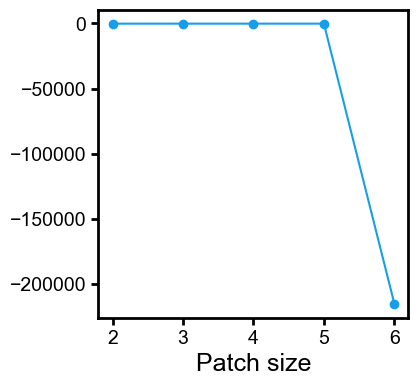

In [4]:
from image_utils import *

test_patches = patches_by_size[patch_sizes[-1]][:100]

log_likelihoods = []
for patch_size in patch_sizes:
    # test_patches = patches_by_size[patch_size][:100]
    cov_mat = cov_mats_stationary_pd[patch_size]
    mean = means[patch_size]
    ll  = compute_stationary_log_likelihood(test_patches, cov_mat, mean, prefer_iterative=False)
    log_likelihoods.append(ll)


# plot mean log likelihood vs patch size
plt.figure(figsize=(4, 4))
plt.plot(patch_sizes, [np.mean(l) for l in log_likelihoods], 'o-')
plt.xlabel('Patch size')




Text(0.5, 0, 'Patch size')

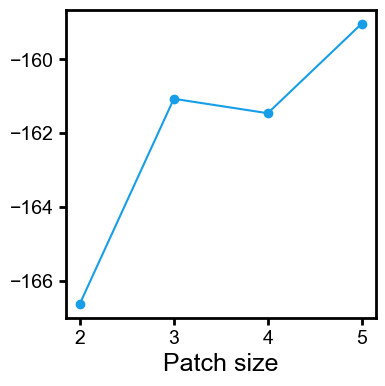

In [6]:
# plot mean log likelihood vs patch size
plt.figure(figsize=(4, 4))
plt.plot(patch_sizes[:4], [np.mean(l) for l in log_likelihoods][:4], 'o-')
plt.xlabel('Patch size')
